In [50]:
import pandas as pd
from EmotionAnalysis.DataSchemaExtractionParsing import *
from EmotionAnalysis.DataPreProcessing import *
from EmotionAnalysis.SentSemanticModule import *
from EmotionAnalysis.SentTweetModule import *
from EmotionAnalysis.SentSyntacticModule import *
from EmotionAnalysis.WordVectorRepresentationImplementations import *
import ast
%matplotlib inline
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# I. Affective Representation of Annotated Dataset:

### Loading Annotated Dataset

In [3]:
plutchik_tweets = pd.read_csv('Data/primary-plutchik-wheel-DFE.csv',encoding="utf-8")
plutchik_tweets = plutchik_tweets[['text','emotion']]
plutchik_tweets.head()

,text,emotion
0,How much of the forecast was genuine and how m...,Neutral
1,I did touch them one time you see but of cours...,Neutral
2,We find that choice theorists admit that they ...,Neutral
3,"Well, here I am with an olive branch.",Neutral
4,"Its rudder and fin were both knocked out, and ...",Neutral


In [5]:
set(plutchik_tweets['emotion'])

{'Aggression',
 'Ambiguous',
 'Anger',
 'Anticipation',
 'Awe',
 'Contempt',
 'Disapproval',
 'Disgust',
 'Fear',
 'Joy',
 'Love',
 'Neutral',
 'Optimism',
 'Remorse',
 'Sadness',
 'Submission',
 'Surprise',
 'Trust'}

In [6]:
selective_8 = ['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust','Neutral']
plutchik_tweets_8emotions = plutchik_tweets[plutchik_tweets['emotion'].isin(selective_8)]

## Visualizing the distribution of emotions in the annotated dataset:

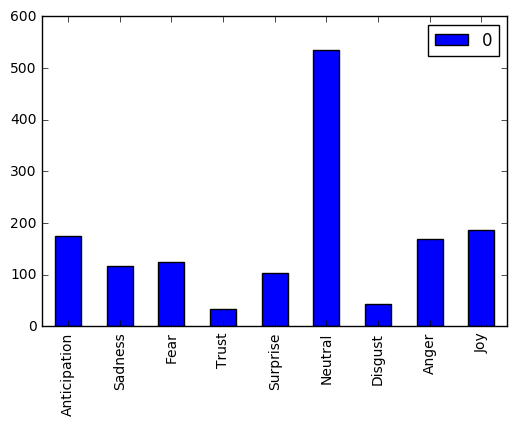

In [7]:
frequency = Counter(plutchik_tweets_8emotions['emotion'])
df = pd.DataFrame.from_dict(frequency, orient='index')
df.plot(kind='bar')

### Applying the same pre-processing pipeline to get affective representation:

In [9]:
tweets_no_contractions = replace_contractions(plutchik_tweets_8emotions)

100%|███████████████████████████████████████| 117/117 [00:00<00:00, 253.08it/s]


### Tokenization of Sentences into words

In [10]:
tokenized_list = bag_of_word_representation(tweets_no_contractions)

100%|████████████████████████████████████| 1483/1483 [00:00<00:00, 7336.30it/s]


### Part of Speech Tagging:

In [11]:
tagged_tweets = pos_tagging(tokenized_list)

100%|█████████████████████████████████████| 1483/1483 [00:03<00:00, 396.57it/s]


### Dependency Parser:

In [9]:
nlp = spacy.load('en')

In [60]:
docs = []
# Joining text:
tweets_text = []
for i in range(0, len(tokenized_list)):
    space = " "
    tweets_text.append(space.join(tokenized_list[i]))
tweets_text[0].encode("utf-8")
for i in range(0, len(tweets_text)):
    doc = nlp(tweets_text[i])
    docs.append(doc)

In [61]:
new_samples = []
for sample in docs:
    new_samples_sub = []
    for word in sample:
        new_samples_sub.append((unicode(word),word.pos_))
    new_samples.append(new_samples_sub)

### Application of Syntactic Rules

In [62]:
new_samples,triple_dependencies = apply_syntactic_rules(docs,new_samples)

In [63]:
i = 2
print "\n<<<< Original tweet text >>>\n"
print tweets_text[i]
print "\n<<<< Syntactic dependencies >>>\n"
print triple_dependencies[i]
print "\n<<<< Tweet after applying syntactic Rules >>>\n"
#print new_samples[i]
new_tweet = []
for (word,pos) in new_samples[i]:
    new_tweet.append(word)
print new_tweet


<<<< Original tweet text >>>

We find that choice theorists admit that they introduce a style of moral paternalism at odds with liberal values

<<<< Syntactic dependencies >>>

[(We, u'nsubj', find), (find, u'ROOT', find), (that, u'mark', admit), (choice, u'compound', theorists), (theorists, u'nsubj', admit), (admit, u'ccomp', find), (that, u'mark', introduce), (they, u'nsubj', introduce), (introduce, u'ccomp', admit), (a, u'det', style), (style, u'dobj', introduce), (of, u'prep', style), (moral, u'amod', paternalism), (paternalism, u'pobj', of), (at, u'prep', introduce), (odds, u'pobj', at), (with, u'prep', odds), (liberal, u'amod', values), (values, u'pobj', with)]

<<<< Tweet after applying syntactic Rules >>>

[u'We', u'find', u'that', u'choice', u'theorists', u'admit', u'that', u'they', u'introduce', u'a', u'style', u'of', u'moral', u'at', u'odds', u'with', u'liberal']


### Named Entity Recognition:

In [12]:
tweet_without_ne = remove_named_entities(tagged_tweets)

100%|█████████████████████████████████████| 1483/1483 [00:03<00:00, 393.24it/s]


### Normalizing POS Tags

In [13]:
normalized_tags = normalize_pos_tags_words(tweet_without_ne)
normalized_tags[1]

100%|███████████████████████████████████| 1483/1483 [00:00<00:00, 67367.98it/s]


[('did', 'v'),
 ('touch', 'v'),
 ('them', 'PRP'),
 ('one', 'CD'),
 ('time', 'n'),
 ('you', 'PRP'),
 ('see', 'v'),
 ('but', 'CC'),
 ('of', 'IN'),
 ('course', 'n'),
 ('there', 'EX'),
 ('was', 'v'),
 ('nothing', 'n'),
 ('doing', 'v'),
 ('he', 'PRP'),
 ('wanted', 'v'),
 ('me', 'PRP')]

### Removal of Punctuation and Stop words and Converting to Lower Case and Removal of Other special categories: url, number, username:

In [14]:
tagged_tweets_without = eliminate_stop_words_punct(normalized_tags)

100%|███████████████████████████████████| 1483/1483 [00:00<00:00, 12049.07it/s]


### Lemmatization:

In [15]:
lemmatized_tweets = lemmatizer(tagged_tweets_without)

lemmatized_tweets_untag = lemmatizer_untagged(tagged_tweets_without)
lemmatized_tweets[0]

100%|███████████████████████████████████| 1483/1483 [00:00<00:00, 17228.57it/s]


[('how', 'WRB'),
 ('much', 'Adj'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('forecast', 'n'),
 ('be', 'v'),
 ('genuine', 'Adj'),
 ('and', 'CC'),
 ('how', 'WRB'),
 ('much', 'Adj'),
 ('be', 'v'),
 ('fix', 'v'),
 ('it', 'PRP'),
 ('be', 'v'),
 ('moot', 'Adj'),
 ('point', 'n')]

### Keeping only NAVA words

In [17]:
nava_tweets = keep_only_nava_words(lemmatized_tweets)
nava_tweets[0]

100%|██████████████████████████████████| 1483/1483 [00:00<00:00, 148215.33it/s]


['much',
 'forecast',
 'be',
 'genuine',
 'much',
 'be',
 'fix',
 'be',
 'moot',
 'point']

In [19]:
print (lemmatized_tweets[0])
print (nava_tweets[0])

[('how', 'WRB'), ('much', 'Adj'), ('of', 'IN'), ('the', 'DT'), ('forecast', 'n'), ('be', 'v'), ('genuine', 'Adj'), ('and', 'CC'), ('how', 'WRB'), ('much', 'Adj'), ('be', 'v'), ('fix', 'v'), ('it', 'PRP'), ('be', 'v'), ('moot', 'Adj'), ('point', 'n')]
['much', 'forecast', 'be', 'genuine', 'much', 'be', 'fix', 'be', 'moot', 'point']


### Storing affective word level representation:

In [70]:
annotated_nava_tweets_df = pd.DataFrame()
annotated_nava_tweets_df['Nava Representation'] = nava_tweets
annotated_nava_tweets_df['Tokenized Lemmatized'] = lemmatizer_raw(tagged_tweets)

#annotated_nava_tweets_df.to_csv('Results/Annotated_Representation.csv')

### USE THIS TO LOAD DIRECTLY ALREADY FINISHED RAW TOKENIZED LEMMATIZED REPRESENTATION

In [27]:
annotated_tweets_df = pd.read_csv('Results/Annotated_Representation.csv')
tokenized_lemma_representation = annotated_tweets_df['Tokenized Lemmatized']
tokenized_lemmatized_tweets = []
for i in range(0, len(tokenized_lemma_representation)):
    result = ast.literal_eval(tokenized_lemma_representation[i])
    tokenized_lemmatized_tweets.append(result)

### USE THIS TO LOAD DIRECTLY ALREADY FINISHED AFFECTIVE REPRESENTATION

In [29]:
affective_representation = annotated_tweets_df['Nava Representation']
nava_tweets = []
for i in range(0, len(affective_representation)):
    result = ast.literal_eval(affective_representation[i])
    nava_tweets.append(result)

# II. Loading Unannotated Tweets

### 1. Loading Raw Lemmatized Representation:

In [26]:
unannotated_tweets_df = pd.read_csv('../../Project_Backup/BigData/Unannotated_Representation/en/Unannotated_Representation_whole.csv')
tokenized_lemma_representation = unannotated_tweets_df['Tokenized Lemmatized']
unnatoted_tokenized_lemmatized_tweets = []
for i in tqdm(range(0, len(tokenized_lemma_representation))):
    result = ast.literal_eval(tokenized_lemma_representation[i])
    unnatoted_tokenized_lemmatized_tweets.append(result)

### 2. Loading Nava Affective Representation:

In [32]:
affective_representation = unannotated_tweets_df['Nava Representation']
unannotated_nava_tweets = []
for i in tqdm(range(0, len(affective_representation))):
    result = ast.literal_eval(affective_representation[i])
    unannotated_nava_tweets.append(result)

100%|█████████████████████████████| 2985994/2985994 [03:44<00:00, 13284.16it/s]


In [46]:
unannotated_nava_tweets[0]

['good', 'town']

# III. Word to Numerical Vector Representation:

### 1. Combining the small annotated dataset and whole unannotated tweets

In [34]:
tokenized_lemma_whole = tokenized_lemmatized_tweets + unnatoted_tokenized_lemmatized_tweets 
len(tokenized_lemma_whole)

2987477

### 2. Training word2Vec on the combined list

In [35]:
# PARAMETERS TO BE TUNED:

# Word vector dimensionality                      
# Minimum word count                        
# Number of threads to run in parallel
# Context window size                                                                                    
# Downsample setting for frequent words

#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    #level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality
min_word_count = 1  # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(tokenized_lemmatized_tweets, workers=num_workers,
            size=num_features, min_count = min_word_count,
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "../../Project_Backup/BigData/Models/semi-supervised-model-en"
model.save(model_name)


C:\Users\fnac\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Training model...


In [47]:
print (model.similarity('laugh','humour'))
print (model.similarity('happy','sad'))

0.989608513985
0.546232699973


## USE THIS TO LOAD DIRECTLY PRE-TRAINED WORD2VEC MODEL:

In [4]:
from gensim.models import Word2Vec
model = Word2Vec.load('../../Project_Backup/BigData/Models/semi-supervised-model-en')

### 3. Word2Vec Representation:

In [51]:
AnnotatedTweets = getAvgFeatureVecs(nava_tweets, model, 300)

In [52]:
UnAnnotatedTweets = getAvgFeatureVecs(unannotated_nava_tweets, model, 300)
len(UnAnnotatedTweets)

2985994

# IV. Training ER models using Machine Learning Algorithms in an Semi-Supervised Manner

* Rational: 
A method for adapting consists in iteratively "auto-labeling" the target examples.
    * a model h is learned from the labeled source examples
    * h automatically labels SOME target examples;
    * a new model is learned from the new labeled examples.

* Trying the following Algorithms with domain adaptation:
    * Random Forest
    * GBM
    * Support Vector Machine with different kernels: linear, radial, polynomial.
    * Naive Bayes: bernoulli,gaussian, multinomial
    * Maximum Entropy 
    * K-nearest Neighbors
    * Decision Trees
* Fine Tuning model parameters:
* Model Evaluation through Cross Validation: 
* Confusion Matrices
* Learning Curves
* Voted Model between Different Algorithms + Lexicon Based

In [54]:
emo_dict = {
    'Anger':0,
    'Anticipation':1,
    'Disgust':2,
    'Fear':3,
    'Joy':4,
    'Sadness':5,
    'Surprise':6,
    'Trust':7,
    'Neutral':8
}
plutchik_tweets_8emotions['emotionId'] = [emo_dict[emotion] for emotion in plutchik_tweets_8emotions['emotion']]

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq\backend\cython\message.c:4018)
    PyErr_CheckSignals()
KeyboardInterrupt
C:\Users\fnac\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 1. Splitting X and y into training and testing:

In [55]:
X_train, X_test, y_train, y_test = train_test_split(AnnotatedTweets,plutchik_tweets_8emotions['emotionId'], test_size=0.3)

In [56]:
# Dealing with Unbalanced Classes:
def weight_sample(labels):
    """ We calculate the percentages for each class and add it to the sample_weights list"""
    
    weight_class = labels.value_counts()/len(labels)
    
    sample_weights = []
    for i in labels:
        sample_weights += [weight_class[i]]
        
    return np.array(sample_weights)

sample_weights = weight_sample(y_train)

## 2. Trying Random Forest with Domain Adaptation:

In [58]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
forest = RandomForestClassifier( n_estimators = 15, max_features = None )

# Training and predicting for only annotated dataset:
print ("Fitting a random forest to labeled training data....")
forest = forest.fit(X_train, y_train,sample_weight= sample_weights) 
result_train = forest.predict(X_train)
result_test = forest.predict(X_test)

iteration = 1
# Training and predicting using domain adaptation in an iterative fashion:
for i in range(0,3000,1000):
    print ("Fitting a random forest to training data using domain adaptation, ITERATION: "+str(iteration))
    
    # Predicting on a small subset of the unannotated dataset:
    subset_results = forest.predict(UnAnnotatedTweets[0+i:1000+i])
    X_train = np.concatenate((X_train,UnAnnotatedTweets[0+i:1000+i]))
    y_train = np.concatenate((y_train,subset_results))
    
    # Retraining model on the new annotated dataset:
    
    forest = forest.fit(X_train, y_train) 
    result_train = forest.predict(X_train)
    
    iteration = iteration + 1

result_test = forest.predict(X_test) # New Predictions for test dataset    

Fitting a random forest to labeled training data....
Fitting a random forest to training data using domain adaptation, ITERATION: 1
Fitting a random forest to training data using domain adaptation, ITERATION: 2
Fitting a random forest to training data using domain adaptation, ITERATION: 3


In [59]:
import matplotlib.pyplot as plt
from sklearn import metrics
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

### Plotting Confusion Matrix for Training:

In [60]:
cm=metrics.confusion_matrix(y_train, result_train)
print(cm)

[[ 460    0    0    0    0    0    0    0    5]
 [   0  433    0    0    1    0    0    0    3]
 [   1    0   40    0    0    0    0    0    0]
 [   0    1    0  107    0    0    0    0    3]
 [   0    0    0    0  335    0    1    0    2]
 [   0    0    0    0    0  111    0    0    3]
 [   0    1    0    0    1    0   81    0    2]
 [   0    0    0    0    0    0    0   29    0]
 [   1    1    0    0    1    0    0    0 2415]]


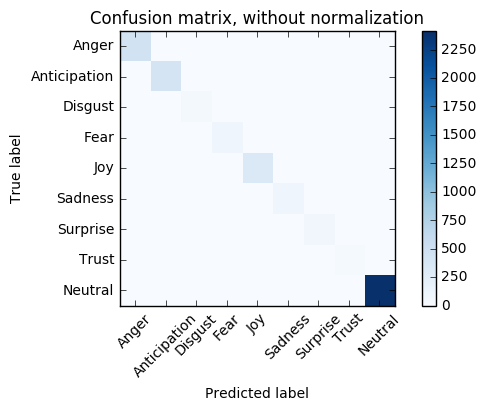

In [64]:
plot_confusion_matrix(cm, classes= ['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust','Neutral'],
                      title='Confusion matrix, without normalization')

## Plotting Confusion Matrix for Testing:

In [62]:
cm_test=metrics.confusion_matrix(y_test, result_test)
print(cm_test)

[[  4   3   0   1   2   0   0   0  25]
 [  6   3   0   0   5   1   0   0  26]
 [  5   1   1   0   0   0   0   0   3]
 [  4   3   0   1   3   1   1   0  30]
 [ 12   3   0   1  12   2   0   0  26]
 [  6   3   1   0   1   0   0   0  25]
 [  4   8   0   2   2   0   2   0  16]
 [  2   1   0   0   1   0   0   1   8]
 [ 17  12   2   2  16   1   0   1 126]]


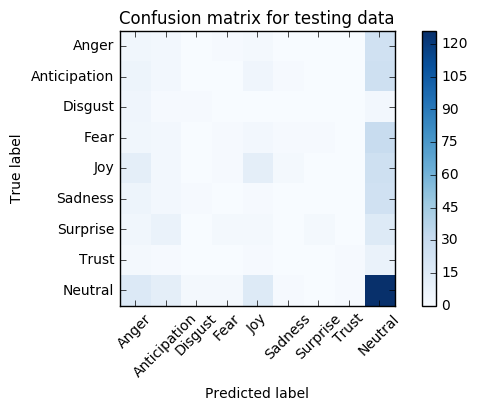

In [65]:
plot_confusion_matrix(cm_test, classes= ['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust','Neutral'],
                      title='Confusion matrix for testing data')

### Model Evaluation: 

### For Training:

In [67]:
print('Accuracy Score: ',metrics.accuracy_score(y_train, result_train))

print('micro Precision Score: ',metrics.precision_score(y_train, result_train, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_train, result_train, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_train, result_train, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_train, result_train, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_train, result_train, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_train, result_train, average='macro'))


Accuracy Score:  0.993313521545
micro Precision Score:  0.993313521545
micro Recall Score:  0.993313521545
micro f1_score:  0.993313521545
macro Precision Score:  0.995591236266
macro Recall Score:  0.981797407375
macro f1_score:  0.988584214656


### For Testing:

In [68]:
print('Accuracy Score: ',metrics.accuracy_score(y_test, result_test))

print('micro Precision Score: ',metrics.precision_score(y_test, result_test, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_test, result_test, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_test, result_test, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_test, result_test, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_test, result_test, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_test, result_test, average='macro'))

Accuracy Score:  0.337078651685
micro Precision Score:  0.337078651685
micro Recall Score:  0.337078651685
micro f1_score:  0.337078651685
macro Precision Score:  0.27056567846
macro Recall Score:  0.152512109705
macro f1_score:  0.152864965797


## Labelling Our Geo-Tweets Using Random Forest:

In [ ]:
resultUnannotatedTweets = forest.predict(UnAnnotatedTweets)
resultUnannotatedTweets_df = pd.DataFrame()
resultUnannotatedTweets_df['Emotion_Id'] = resultUnannotatedTweets

emo_dict = {
    0: 'Anger',
    1: 'Anticipation',
    2: 'Disgust',
    3: 'Fear',
    4: 'Joy',
    5: 'Sadness',
    6: 'Surprise',
    7: 'Trust',
    8: 'Neutral'
}

resultUnannotatedTweets_df['Emotion'] = [emo_dict[emotion_id] for emotion_id in resultUnannotatedTweets_df['Emotion_Id'] ]
frequency = Counter(resultUnannotatedTweets_df['Emotion'])
df = pd.DataFrame.from_dict(frequency, orient='index')
df.plot(kind='bar')

## 3. Trying SVM with Different Kernels: (linear, radial, polynomial)
Separating hyperplane for unbalanced classes

In [307]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
C = 1.0 # PARAMETERS TO BE FINE TUNED 
gamma = 0.7 # PARAMETERS TO BE FINE TUNED
degree = 9 # PARAMETERS TO BE FINE TUNED
lin_svc = svm.SVC(kernel='linear', C=C, class_weight={1: 9}).fit(X_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=gamma, C=C,class_weight={1: 9}).fit(X_train, y_train)
poly_svc = svm.SVC(kernel='poly', degree=degree, C=C).fit(X_train, y_train)

In [308]:
result_train_svm_lin = lin_svc.predict(X_train)
result_test_svm_lin = lin_svc.predict(X_test)

In [309]:
result_train_svm_rbf = rbf_svc.predict(X_train)
result_test_svm_rbf = rbf_svc.predict(X_test)

In [310]:
result_train_svm_poly = poly_svc.predict(X_train)
result_test_svm_poly = poly_svc.predict(X_test)

## Labelling Our Geo-Tweets Using Linear SVM:

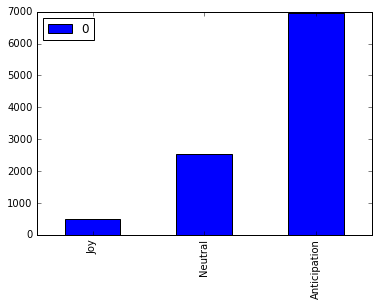

In [312]:
resultUnannotatedTweets = lin_svc.predict(UnAnnotatedTweets)
resultUnannotatedTweets_df = pd.DataFrame()
resultUnannotatedTweets_df['Emotion_Id'] = resultUnannotatedTweets

resultUnannotatedTweets_df['Emotion'] = [emo_dict[emotion_id] for emotion_id in resultUnannotatedTweets_df['Emotion_Id'] ]
frequency = Counter(resultUnannotatedTweets_df['Emotion'])
df = pd.DataFrame.from_dict(frequency, orient='index')
df.plot(kind='bar')

### Model Evaluation: 

### For Training:

In [272]:
print('Accuracy Score: ',metrics.accuracy_score(y_train, result_train_svm))

print('micro Precision Score: ',metrics.precision_score(y_train, result_train_svm, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_train, result_train_svm, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_train, result_train_svm, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_train, result_train_svm, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_train, result_train_svm, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_train, result_train_svm, average='macro'))


# Customized Version of AUC for multiple classes
fpr, tpr, thresholds = metrics.roc_curve(y_train, result_train_svm, pos_label=10)
print('roc_auc_score: ',metrics.auc(fpr, tpr))

('Accuracy Score: ', 0.63397721644378402)
('micro Precision Score: ', 0.63397721644378402)
('micro Recall Score: ', 0.63397721644378402)
('micro f1_score: ', 0.63397721644378402)
('macro Precision Score: ', 0.58142407484252123)
('macro Recall Score: ', 0.23550161508731091)
('macro f1_score: ', 0.23888227421443237)
('roc_auc_score: ', 0.71729587277127349)


### For Testing:

In [3]:
print('Accuracy Score: ',metrics.accuracy_score(y_test, result_test_svm))

print('micro Precision Score: ',metrics.precision_score(y_test, result_test_svm, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_test, result_test_svm, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_test, result_test_svm, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_test, result_test_svm, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_test, result_test_svm, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_test, result_test_svm, average='macro'))


# Customized Version of AUC for multiple classes
fpr, tpr, thresholds = metrics.roc_curve(y_test, result_test_svm, pos_label=10)
print('roc_auc_score: ',metrics.auc(fpr, tpr))

NameError: name 'metrics' is not defined